In [1]:
# Imports
from os import chdir
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import sknetwork
import seaborn as sns

In [2]:
# Move up two directories, to project base directory
chdir("../..")

In [3]:
# Import reviews
# Probably an unnecessary use of dask
df_reviews = dd.read_parquet("data/reviews.parquet/").compute()

In [4]:
# Generates edge list for negative reviews by subsetting negative reviews to author and game (nodes)
df_edges = df_reviews[df_reviews["voted_up"] == False][["author_steamid", "steam_appid"]]

In [5]:
# Node IDs are integers in scikit-network, so I renumber all nodes (authors/games).
# Scikit-network doesn't care that the graph is bipartite for the purpose of node IDing, so app IDs will start where author IDs end.

# Gets unique authors
set_authors = df_edges["author_steamid"].unique()
# Creates dictionary mapping steam's author identifier to integers 0 through the number of unique authors minus one.
dict_author_mapping = {set_authors[i]: i for i in range(len(set_authors))}

# Same as above, but we offset the generated ID by the numbers of ID already used for author nodes
set_apps = df_edges["steam_appid"].unique()
dict_app_mapping = {set_apps[i]: i + len(dict_author_mapping) for i in range(len(set_apps))}

In [6]:
# Applies node ID mappings
df_edges["author_steamid"] = df_edges["author_steamid"].map(dict_author_mapping)
df_edges["steam_appid"] = df_edges["steam_appid"].map(dict_app_mapping)

In [7]:
# Turns edge list from dataframe to list of tuples
list_edges = list(df_edges.itertuples(index=False, name=None))

In [8]:
# Generates adjacency matrix from edge list
csr_adjacency = sknetwork.data.from_edge_list(
    list_edges,
    bipartite=True,  # Honestly not sure if this flag does anything
    shape=(list_edges[0][1], list_edges[-1][1] + 1),  # See comment below
)

# For a bipartite graph where partition one has m nodes and partition two has n nodes, I'd expect the size of the adjacency matrix to be m x n.
# However, scikit-network does not enforce that the graph is bipartite, so the adjacency matrix could have dimensions (m + n) * (m + n).
# HOWEVER, scikit-network doesn't need empty rows/columns, so the actual dimensions are (m + n) * m.

# In my implementation m happens to be bigger than n, so my graph is unnecessarily large (m = number of authors, n = number of games, m >> n)...
#   Fixing this just now doesn't seem like a good use of my time, and the matrix is sparse so (I'm hoping) I don't incur *too* great a performance

In [9]:
# Instantiates Leiden clusterer
# I'm using Leiden instead of Louvain because Louvain is supposed to be pretty fast and Leiden is supposed to be better than Louvain
#   (At least, that's what the authors of the Leiden algorithm claim)
# Verbose for output, random_state=42 for reproducibility
clusterer = sknetwork.clustering.Leiden(verbose=1, random_state=42)

In [10]:
# Finds clusters
labels = clusterer.fit_predict(csr_adjacency)

Aggregation: 1  Clusters: 908399  Increase: 0.6474263668060303
Aggregation: 2  Clusters: 887022  Increase: 0.05654296651482582
Aggregation: 3  Clusters: 885812  Increase: 0.0034256395883858204
Aggregation: 4  Clusters: 885729  Increase: 9.892060188576579e-05


In [11]:
# Gets rid of app clusters with < 5 members
# Generates dataframe of app clusters (records are apps, field 0 is cluster IDs) from per-node app clusters 
#   (clusterer.labels_col_ has the clusters for nodes in columns, column nodes are author nodes followed by app nodes)
df_app_clusters = pd.DataFrame.from_dict(
    {key: clusterer.labels_col_[dict_app_mapping[key]] for key in dict_app_mapping},
    orient="index",
)

# Gets list of app clusters with < 5 members
clusters = df_app_clusters[0]
bad_clusters = clusters[df_app_clusters[0] < 5].index.values

# Gets list of app clusters with >= 5 members
good_clusters = clusters[df_app_clusters[0] >= 5].index.values

# List comprehension to generate dictionary for mapping bad clusters onto a new cluster (all bad clusters will be combined into this new cluster)
dict_cluster_culling_mapping = {i: df_app_clusters.max()[0] + 1 for i in bad_clusters}

# Adds passthroguh mappings for good app clusters
for good_cluster in good_clusters:
    dict_cluster_culling_mapping[good_cluster] = good_cluster

# Applies mapping
df_app_clusters[0] = df_app_clusters[0].map(dict_cluster_culling_mapping)

KeyboardInterrupt: 

In [ ]:
# Renumbers cluster IDs to start from zero

# List comprehension to renumber app ids
dict_cluster_reindex_mapping = {
    old_cluster_id: new_cluster_id
    for new_cluster_id, old_cluster_id in enumerate(df_app_clusters[0].unique())
}

# Applies mapping
df_app_clusters[0] = df_app_clusters[0].map(dict_cluster_reindex_mapping)

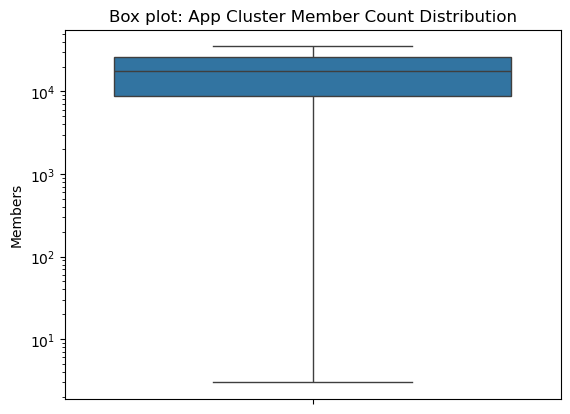

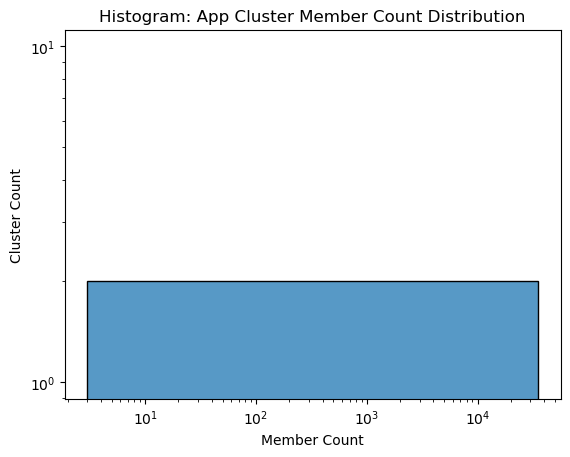

count        2.000000
mean     17590.500000
std      24872.481028
min          3.000000
25%       8796.750000
50%      17590.500000
75%      26384.250000
max      35178.000000
Name: count, dtype: float64
Percent of clusters with <= 1 apps: 0.0
Percent of clusters with <= 2 apps: 0.0
Percent of clusters with <= 4 apps: 0.002842443364315966
Percent of clusters with <= 8 apps: 0.002842443364315966
Percent of clusters with <= 16 apps: 0.002842443364315966
Percent of clusters with <= 32 apps: 0.002842443364315966


In [ ]:
# Boxplot of cluster member counts
sns.boxplot(
    df_app_clusters.groupby(0).value_counts(),
)
plt.ylabel('Members')
plt.yscale("log")
plt.title('Box plot: App Cluster Member Count Distribution')
plt.show()

# Plots histogram of app cluster membership
sns.histplot(
    df_app_clusters.groupby(0).value_counts(), log_scale=(True, False), bins="doane"
)
plt.yscale("log")
plt.xlabel('Member Count')
plt.ylabel('Cluster Count')
plt.title('Histogram: App Cluster Member Count Distribution')
plt.show()

# Prints some descriptive statistics
print(df_app_clusters[0].value_counts().describe())
for i in range(6):
    print(
        f"Percent of clusters with <= {2**i} apps: {(df_app_clusters[0].value_counts() <= 2**i).sum()/len(df_app_clusters) * 100}"
    )

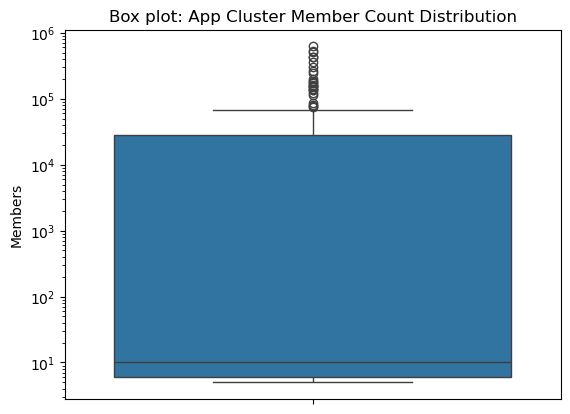

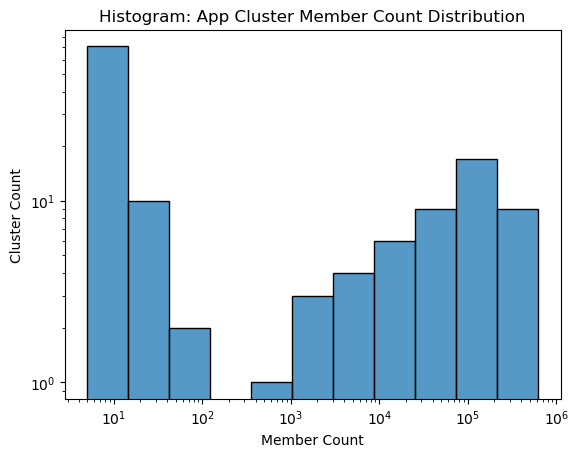

count       132.000000
mean      49656.234848
std      113161.319931
min           5.000000
25%           6.000000
50%          10.000000
75%       28279.500000
max      622527.000000
Name: count, dtype: float64
Percent of clusters with <= 1 apps: 0.0
Percent of clusters with <= 2 apps: 0.0
Percent of clusters with <= 4 apps: 0.0
Percent of clusters with <= 8 apps: 0.0009001280470287917
Percent of clusters with <= 16 apps: 0.0011289741606801795
Percent of clusters with <= 32 apps: 0.0012205126061407346


In [ ]:
# Same as blocks above, but for authors.
# Will create a helper function to replace redundant code at some point, but it's a low priority.

df_author_clusters = pd.DataFrame.from_dict(
    {
        key: clusterer.labels_row_[dict_author_mapping[key]]
        for key in dict_author_mapping
    },
    orient="index",
)

clusters = df_author_clusters[0].value_counts() < 5
bad_clusters = clusters[clusters].index.values
good_clusters = clusters[clusters == False].index.values

mapping_bad_clusters = {i: df_author_clusters.max()[0] + 1 for i in bad_clusters}
for good_cluster in good_clusters:
    mapping_bad_clusters[good_cluster] = good_cluster

df_author_clusters[0] = df_author_clusters[0].map(mapping_bad_clusters)

dict_author_cluster_mapping = {}
for i, cluster in enumerate(df_author_clusters[0].unique()):
    dict_author_cluster_mapping[cluster] = i


df_author_clusters[0] = df_author_clusters[0].map(dict_author_cluster_mapping)

# Boxplot of cluster member counts
sns.boxplot(
    df_author_clusters.groupby(0).value_counts(),
)
plt.ylabel('Members')
plt.yscale("log")
plt.title('Box plot: App Cluster Member Count Distribution')
plt.show()

# Plots histogram of app cluster membership
sns.histplot(
    df_author_clusters.groupby(0).value_counts(), log_scale=(True, False), bins="doane"
)
plt.yscale("log")
plt.xlabel('Member Count')
plt.ylabel('Cluster Count')
plt.title('Histogram: App Cluster Member Count Distribution')
plt.show()

# Prints some descriptive statistics
print(df_author_clusters[0].value_counts().describe())
for i in range(6):
    print(
        f"Percent of clusters with <= {2**i} apps: {(df_author_clusters[0].value_counts() <= 2**i).sum()/len(df_author_clusters) * 100}"
    )

In [ ]:
# Subsets reviews dataframe to columns for output
df_reviews_clustered = df_reviews[["author_steamid", "steam_appid"]].copy()

# Creates cluster ID columns via mapping author & app ids (using cleaned dataframes)
df_reviews_clustered["author_cluster"] = df_reviews_clustered["author_steamid"].map(
    df_author_clusters.to_dict()[0]
)
df_reviews_clustered["app_cluster"] = df_reviews_clustered["steam_appid"].map(
    df_app_clusters.to_dict()[0]
)

# Drops reviews without valid clusters
df_reviews_clustered = df_reviews_clustered.dropna()

# Coerces cluster IDs to integers
df_reviews_clustered["author_cluster"] = df_reviews_clustered["author_cluster"].astype(int)
df_reviews_clustered["app_cluster"] = df_reviews_clustered["app_cluster"].astype(int)

# Spot-check
df_reviews_clustered.head()

,author_steamid,steam_appid,author_cluster,app_cluster
recommendationid,,,,
92426316,76561197991126058,1000000,0,0
92738312,76561198043369921,1000000,0,0
95149549,76561198308633526,1000000,1,0
116584366,76561197990036156,1000000,0,0
129441214,76561198281676677,1000000,0,0


In [ ]:
df_reviews_clustered.to_parquet("models/clusters/negative_clusters.parquet")